In [2]:
import sys 
sys.path.append("/mnt/shared/users/wessim.omezzine/hip-analysis")
from hip.analysis.aoi import AnalysisArea
from hip.analysis.data._datasources import DATASOURCE_CONFIGS
import os
import dask
from dask.distributed import Client, progress
import rioxarray as rxr
import glob
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime


import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import rasterio

import warnings
warnings.filterwarnings("ignore")

import s3fs
import xarray as xr
import dask
# Create a dask client to distribute (speed up) the coputation

# if dashboard.link set to default value and running behind hub, make dashboard link go via proxy
if dask.config.get("distributed.dashboard.link") == '{scheme}://{host}:{port}/status':
    jup_prefix = os.environ.get('JUPYTERHUB_SERVICE_PREFIX')
    if jup_prefix is not None:
        jup_prefix = jup_prefix.rstrip('/')
        dask.config.set({"distributed.dashboard.link": f"{jup_prefix}/proxy/{{port}}/status"})

client = Client()
client

GDAL_DATA                    = /envs/user/fix_hdc/share/gdal
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5
AWS_ACCESS_KEY_ID            = xx..xx
AWS_SECRET_ACCESS_KEY        = xx..xx
AWS_SESSION_TOKEN            = xx..xx


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:46111
INFO:distributed.scheduler:  dashboard at:  /user/wessim.omezzine/proxy/8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34697'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41085'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38651'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33549'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45289', name: 3, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45289
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:45052
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:40769', na

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/wessim.omezzine/proxy/8787/status,
Dashboard: /user/wessim.omezzine/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46111,Workers: 4
Dashboard: /user/wessim.omezzine/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.20 GiB
Comm: tcp://127.0.0.1:40769,Total threads: 1
Dashboard: /user/wessim.omezzine/proxy/43981/status,Memory: 3.80 GiB
Nanny: tcp://127.0.0.1:34697,


In [4]:
region="Indonesia"
start_season =2
end_season =7

In [ ]:
bbox = (110.214844,-2.416276,116.037598,1.515936) 
area = AnalysisArea(
    bbox=bbox,
    datetime_range="1983-01-01/2023-06-30"  # change the starting date 1983  
)
r1h = area.get_dataset(["CHIRPS","r1h_dekad"])
r2h = area.get_dataset(["CHIRPS","r2h_dekad"])
r3h = area.get_dataset(["CHIRPS","r3h_dekad"])


In [ ]:
r1h = r1h.load()
r2h = r2h.load()
r3h = r3h.load()

In [ ]:
r1h = r1h.sel(time=(r1h['time.month'] >= start_season) & (r1h['time.month'] <end_season), drop=True)
r2h = r2h.sel(time=(r2h['time.month'] >= start_season) & (r2h['time.month'] <end_season), drop=True)
r3h = r3h.sel(time=(r3h['time.month'] >= start_season) & (r3h['time.month'] <end_season), drop=True)


In [13]:
path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/0{start_season-1}/01'

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":70, "ensemble":-1}, engine='zarr')
ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 

INFO:distributed.utils_perf:full garbage collection released 104.08 MiB from 211 reference cycles (threshold: 9.54 MiB)


In [14]:
ds_issue = ds_issue.tp.load()

In [15]:
da_issue= ds_issue.groupby("time.year").apply(lambda da :  da.diff(dim='time', n=1))
da_issue = da_issue.mean("ensemble") #Output 1 ensemble
#da_issue = da_issue.diff(dim='time', n=1).fillna(0)  # Non cumulative

In [17]:
# DONT RUN only for dekad!!!!!

np.set_printoptions(threshold=np.inf)

from hdc.algo.accessors import Dekad
from odc import stac
import datetime

def dekad_to_date(dekad):
    dek = str(dekad)
    DEKAD = {'1':1,'2':11,'3':21}
    
    return np.datetime64(datetime.date(int(dek[:4]), int(dek[4:6]), DEKAD[dek[-1]]))



start_date = datetime.datetime(1983,1,1)
end_date = datetime.datetime(2023,6,21)

da_issue_dek = da_issue.sel(time=slice(start_date, end_date))
da_issue_dek = da_issue_dek.where(da_issue_dek.time.dt.month.isin(range(start_season, end_season)), drop=True)
da_issue_dek = da_issue_dek.assign_coords(dek=Dekad(da_issue_dek.time).label)
da_issue_dek = da_issue_dek.groupby(da_issue_dek.dek).sum()

time = [dekad_to_date(dekad.values) for dekad in da_issue_dek.dek]
da_issue_dek['dek'] = time

da_issue  =da_issue_dek.rename(dek='time')

In [18]:
window_size = 3  # Number of previous dates to include in the sum
da_issue_agg = da_issue.rolling(time=window_size, min_periods=window_size).sum()
# da_issue_agg = da_issue.isel(time=slice(window_size - 1, None))
da_issue_agg =  da_issue_agg.combine_first(da_issue)

In [11]:
r1h_resample = r1h.sel(latitude = slice(1.5, -1.5 ), longitude = slice(110.5, 115.5))
r2h_resample = r2h.sel(latitude = slice(1.5, -1.5 ), longitude = slice(110.5, 115.5))
r3h_resample = r3h.sel(latitude = slice(1.5, -1.5 ), longitude = slice(110.5, 115.5))

latitude_size, longitude_size = 32,32

r1h = r1h_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
r2h = r2h_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
r3h = r3h_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))

r1h  = r1h.isel(time=slice(2,None))
r2h  = r2h.isel(time=slice(2,None))
r3h  = r3h.isel(time=slice(2,None))

In [19]:
da_monthly_sum_season_near = da_issue_agg.rio.write_crs(ds_issue.rio.crs).rio.reproject(r1h.rio.crs, 
                                                             resolution=(-0.05,0.05), 
                                                             resampling=rasterio.enums.Resampling.nearest)

da_monthly_sum_season_near = da_monthly_sum_season_near.rename({'y': 'latitude', 'x': 'longitude'})
da_monthly_sum_season_near = da_monthly_sum_season_near 


da_monthly_sum_season_near_resample =da_monthly_sum_season_near.sel(latitude = r1h_resample.latitude.values, longitude= r1h_resample.longitude.values, method = "nearest")



da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))

In [20]:
da_monthly_sum_season_near  = da_monthly_sum_season_near.isel(time=slice(2,None))


In [21]:
scaling_factors = 1e3
print(scaling_factors)
forecast = da_monthly_sum_season_near*scaling_factors

1000.0


In [23]:
forecast.time,r1h.time

(<xarray.DataArray 'time' (time: 613)>
 array(['1983-02-21T00:00:00.000000000', '1983-03-01T00:00:00.000000000',
        '1983-03-11T00:00:00.000000000', ..., '2023-06-01T00:00:00.000000000',
        '2023-06-11T00:00:00.000000000', '2023-06-21T00:00:00.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
   * time         (time) datetime64[ns] 1983-02-21 1983-03-01 ... 2023-06-21
     spatial_ref  int64 0,
 <xarray.DataArray 'time' (time: 613)>
 array(['1983-02-21T00:00:00.000000000', '1983-03-01T00:00:00.000000000',
        '1983-03-11T00:00:00.000000000', ..., '2023-06-01T00:00:00.000000000',
        '2023-06-11T00:00:00.000000000', '2023-06-21T00:00:00.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
     spatial_ref  int32 4326
   * time         (time) datetime64[ns] 1983-02-21 1983-03-01 ... 2023-06-21)

In [12]:
r1h.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/r1h.nc')
r2h.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/r2h.nc')
r3h.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/r3h.nc')

In [25]:
forecast.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')


In [27]:
forecast_near = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/r1h.nc')

In [5]:
r1h = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/r1h.nc')
r2h = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/r2h.nc')
r3h = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/r3h.nc')

In [6]:
r1h_lta = r1h.sel(time=slice("1983-02-21","2018-05-31"))
r1h_lta  = r1h_lta .groupby(r1h_lta.time.dt.strftime("%m-%d")).mean()
r1h_lta = r1h_lta.sel(strftime=r1h.time.dt.strftime("%m-%d"))


r2h_lta = r2h.sel(time=slice("1983-02-21","2018-05-31"))
r2h_lta  = r2h_lta .groupby(r2h_lta.time.dt.strftime("%m-%d")).mean()
r2h_lta = r2h_lta.sel(strftime=r2h.time.dt.strftime("%m-%d"))

r3h_lta = r3h.sel(time=slice("1983-02-21","2018-05-31"))
r3h_lta  = r3h_lta .groupby(r3h_lta.time.dt.strftime("%m-%d")).mean()
r3h_lta = r3h_lta.sel(strftime=r3h.time.dt.strftime("%m-%d"))

In [30]:
rfh_lta = rfh.sel(time=slice("1983-02-21","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))

In [8]:
r1h_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/r1h_lta.nc')
r2h_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/r2h_lta.nc')
r3h_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/r3h_lta.nc')

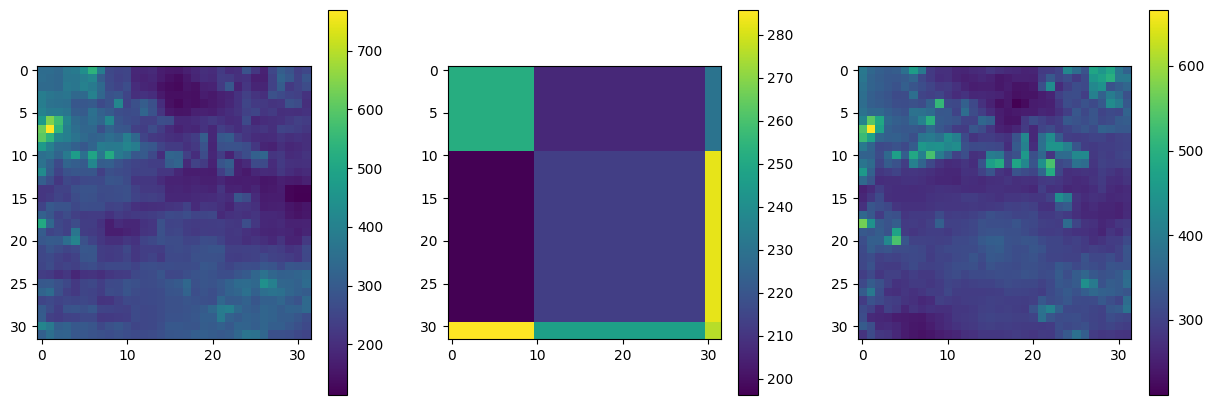

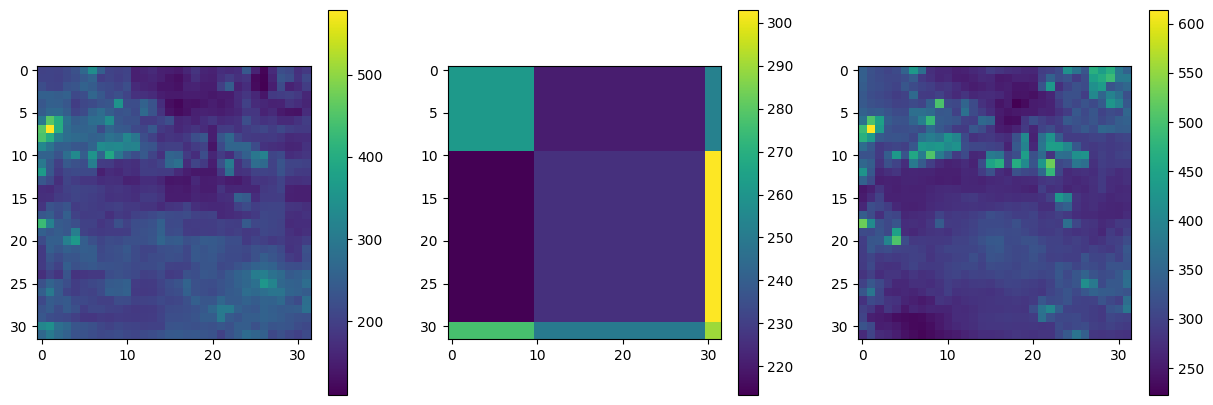

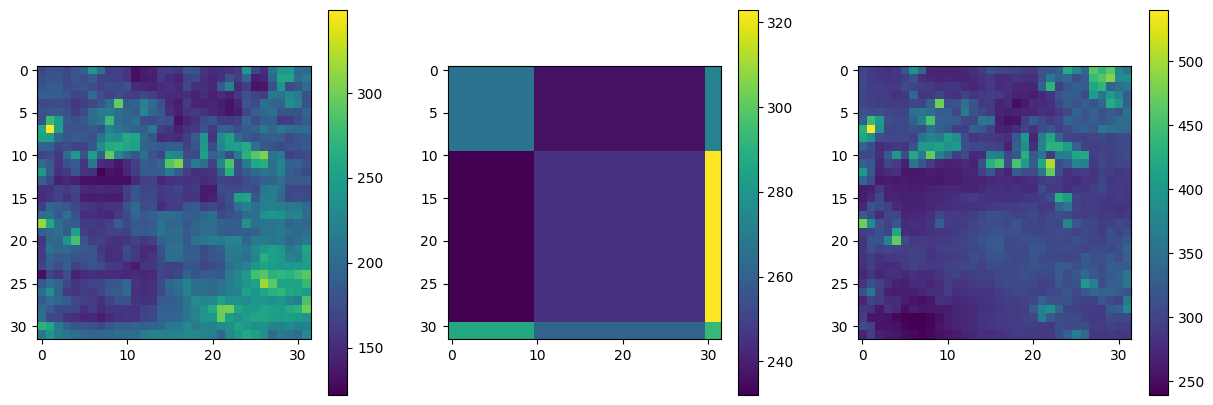

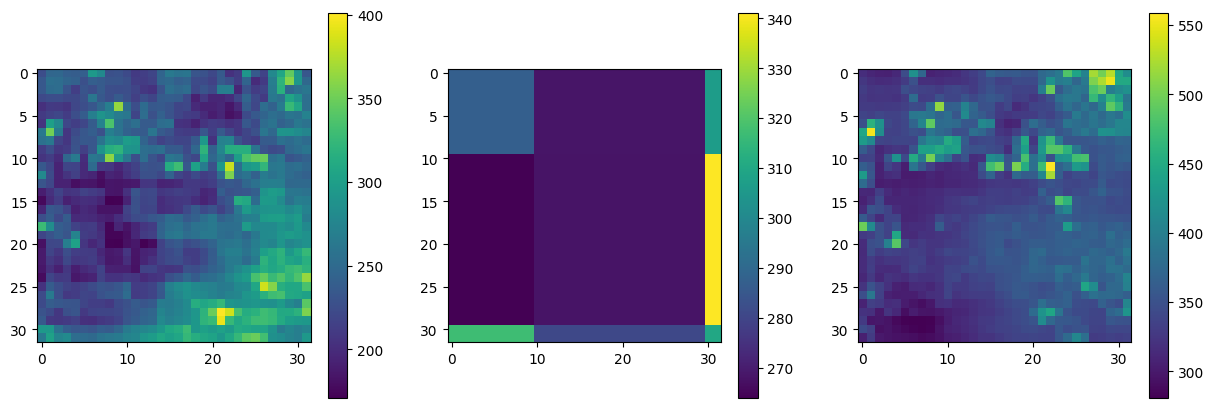

In [32]:
for index in range(4):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    im1 = axes[0].imshow(rfh['band'][index])

    im2 = axes[1].imshow(forecast_near['tp'][index])

    im3 = axes[2].imshow(rfh_lta['band'][index])
    

    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)

    plt.show()


In [2]:
import numpy as np

In [12]:
data = np.load('Data/Downscaling/Rainfall/Indonesia/data_npz/train/1984_00_inp.npz')
data["rfh_lta"].shape, data["forecast"].shape

((15, 1, 32, 32), (15, 1, 32, 32))

In [11]:
data = np.load('Data/Downscaling/Rainfall/Indonesia/data_npz/train/1984_00_out.npz')
data["rfh"].shape

(15, 1, 32, 32)

In [6]:
import sys
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/climax')
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/')
import torch 
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.transforms import transforms
import torch.nn.functional as F
from prettytable import PrettyTable
from scipy import stats

import loralib as lora
from skimage.metrics import structural_similarity as ssim


from climax.climate_downscaling.module import ClimateDownscalingModule
from climax.climate_downscaling.datamodule import ClimateDownscalingDataModule
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning import Trainer
from climax.arch import ClimaX


TASK_TO_RANGE = {
    '0 days' : 0,
    '10 days' : 1,
    '40 days': 4,
    '50 days': 5,
    '60 days': 6,
    '20 days': 2,
    '30 days': 3,
}

In [7]:
net_args = {
    'default_vars': [
        'forecast', 'rfh_lta', 'rfh','r2h','r3h']
    ,"img_size" :  [32, 32],
      "patch_size" :  2,
      "embed_dim":   2048,
      "depth" : 5,
      "decoder_depth" :  2,
      "num_heads": 8,
    "mlp_ratio": 2,
    "drop_path": 0.5,
    "drop_rate": 0.5,
    
}
net = ClimaX(**net_args)
model = ClimateDownscalingModule(net=net, pretrained_path='ClimaX/exps/downscale/checkpoints/epoch_017.ckpt')



Loading pre-trained checkpoint from: ClimaX/exps/downscale/checkpoints/epoch_017.ckpt
<All keys matched successfully>


In [8]:
named_params = list(model.named_parameters())

# Now you can access and view the named parameters
for name, param in named_params:
    print(f"Parameter name: {name}, Parameter shape: {param.shape}")


Parameter name: net.var_embed, Parameter shape: torch.Size([1, 5, 2048])
Parameter name: net.var_query, Parameter shape: torch.Size([1, 1, 2048])
Parameter name: net.pos_embed, Parameter shape: torch.Size([1, 256, 2048])
Parameter name: net.token_embeds.0.proj.weight, Parameter shape: torch.Size([2048, 1, 2, 2])
Parameter name: net.token_embeds.0.proj.bias, Parameter shape: torch.Size([2048])
Parameter name: net.token_embeds.1.proj.weight, Parameter shape: torch.Size([2048, 1, 2, 2])
Parameter name: net.token_embeds.1.proj.bias, Parameter shape: torch.Size([2048])
Parameter name: net.token_embeds.2.proj.weight, Parameter shape: torch.Size([2048, 1, 2, 2])
Parameter name: net.token_embeds.2.proj.bias, Parameter shape: torch.Size([2048])
Parameter name: net.token_embeds.3.proj.weight, Parameter shape: torch.Size([2048, 1, 2, 2])
Parameter name: net.token_embeds.3.proj.bias, Parameter shape: torch.Size([2048])
Parameter name: net.token_embeds.4.proj.weight, Parameter shape: torch.Size([20

In [9]:
lora.mark_only_lora_as_trainable(model)

In [10]:
named_params = list(model.named_parameters())

# Now you can access and view the named parameters
for name, param in named_params:
    print(f"Parameter name: {name}, Parameter shape: {param.shape}")


Parameter name: net.var_embed, Parameter shape: torch.Size([1, 5, 2048])
Parameter name: net.var_query, Parameter shape: torch.Size([1, 1, 2048])
Parameter name: net.pos_embed, Parameter shape: torch.Size([1, 256, 2048])
Parameter name: net.token_embeds.0.proj.weight, Parameter shape: torch.Size([2048, 1, 2, 2])
Parameter name: net.token_embeds.0.proj.bias, Parameter shape: torch.Size([2048])
Parameter name: net.token_embeds.1.proj.weight, Parameter shape: torch.Size([2048, 1, 2, 2])
Parameter name: net.token_embeds.1.proj.bias, Parameter shape: torch.Size([2048])
Parameter name: net.token_embeds.2.proj.weight, Parameter shape: torch.Size([2048, 1, 2, 2])
Parameter name: net.token_embeds.2.proj.bias, Parameter shape: torch.Size([2048])
Parameter name: net.token_embeds.3.proj.weight, Parameter shape: torch.Size([2048, 1, 2, 2])
Parameter name: net.token_embeds.3.proj.bias, Parameter shape: torch.Size([2048])
Parameter name: net.token_embeds.4.proj.weight, Parameter shape: torch.Size([20

In [1]:
import torch

# Check for the number of available GPUs
num_gpus = torch.cuda.device_count()

print(f"Number of GPUs available: {num_gpus}")



Number of GPUs available: 1
